<a href="https://colab.research.google.com/github/danielel013/Census_dataset/blob/master/Census_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Activation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit
import keras

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.8287861040000024
GPU (s):
0.10427039299999308
GPU speedup over CPU: 27x


In [ ]:
!nvidia-smi


Wed Sep  9 06:16:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    51W /  70W |   1701MiB / 15079MiB |     38%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()


True

# Mounting Data and Preprocessing

Mounting drive and files:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn
from sklearn import base
from sklearn import tree
from sklearn import preprocessing, model_selection, svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report


#the dataset was uploaded to drive under foler 'Dataset'
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']

#loading data
train_data = pd.read_csv('drive/My Drive/Dataset/adult.data', names=columns, 
             sep=' *, *', na_values='?')
test_data  = pd.read_csv('drive/My Drive/Dataset/adult.test', names=columns, 
             sep=' *, *', skiprows=1, na_values='?')

#to check data integrity(finding null values, and seeing that all columns we're loaded)
train_data.info()
test_data.info()
#while running this we found that following columns had null values: Workclass, Occupation, Native country
#this was found in both train and test set



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AHZoOWH8SOuFAPS5Ff1s4QjRQQuVGAMrHFkkcbaPL_9jTL1CLztpr8
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlgwt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours/Week      32561 non-null  int64 
 13  Native country  31978 non-null  object
 14  Income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (tot

data pre-processing:

In [ ]:


#concatenating train and test that were in seperate files. we will seperate them later as needed.
df = pd.concat([train_data, test_data], axis=0)

#creating df coppies 
viz_df=df #for visualizations
df2=df #backup


#Dropping rows with Null values. this is one possible strategy- other ones might be using the most common value in a column to replace null values,
#or just using as-is if we have a model that can handle missing values- such as XGboost.
#dropping means that we will be left with the amount of rows in the column with highest amount of null values.

df["Income"].value_counts()
df['Income'] = df['Income'].map({'<=50K':0, '>50K':1})

df.drop('Education', axis=1,inplace=True)
df = df.dropna()

df.info()

categorical_columns = df.select_dtypes(exclude=np.number).columns
new_df = pd.get_dummies(data=df, prefix=categorical_columns, drop_first=True)
#new_df= df after dummies
new_df.shape

new_df.info() 


##Train-test split:
#new_df=new_df.dropna()
X = new_df.drop('Income', axis=1)
y = new_df['Income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             30162 non-null  int64  
 1   Workclass       30162 non-null  object 
 2   fnlgwt          30162 non-null  int64  
 3   Education num   30162 non-null  int64  
 4   Marital Status  30162 non-null  object 
 5   Occupation      30162 non-null  object 
 6   Relationship    30162 non-null  object 
 7   Race            30162 non-null  object 
 8   Sex             30162 non-null  object 
 9   Capital Gain    30162 non-null  int64  
 10  Capital Loss    30162 non-null  int64  
 11  Hours/Week      30162 non-null  int64  
 12  Native country  30162 non-null  object 
 13  Income          30162 non-null  float64
dtypes: float64(1), int64(6), object(7)
memory usage: 3.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 82 columns):


# Visualizations

In [ ]:
viz_df = df.dropna()

viz_df["Workclass"].value_counts()


Private             22286
Self-emp-not-inc     2499
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: Workclass, dtype: int64

In [ ]:
viz_df["Occupation"].value_counts()

Prof-specialty       4038
Craft-repair         4030
Exec-managerial      3992
Adm-clerical         3721
Sales                3584
Other-service        3212
Machine-op-inspct    1966
Transport-moving     1572
Handlers-cleaners    1350
Farming-fishing       989
Tech-support          912
Protective-serv       644
Priv-house-serv       143
Armed-Forces            9
Name: Occupation, dtype: int64

In [ ]:

viz_df["Workclass"]= viz_df["Workclass"].astype(str) 
viz_df["Occupation"]= viz_df["Occupation"].astype(str) 

viz_df['Workclass'].replace(to_replace= ["Never-worked","Without-pay" ,"Private", "Self-emp-not-inc", "Local-gov", "State-gov", "Self-emp-inc", "Federal-gov"], value=[2,4,6,8,10,12,14,16], inplace= True)

viz_df['Occupation'].replace(('Prof-specialty','Craft-repair','Exec-managerial','Adm-clerical','Sales','Other-service','Machine-op-inspct',
                            'Transport-moving','Handlers-cleaners','Farming-fishing','Tech-support','Protective-serv','Priv-house-serv','Armed-Forces'),(1,2,3,4,5,6,7,8,9,10,11,12,13,14),inplace= True)



viz_df.sample(10)


,Age,Workclass,fnlgwt,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country,Income
8763,26,6,247025,10,Never-married,9,Not-in-family,White,Male,0,0,40,United-States,0.0
23386,30,6,165503,13,Never-married,5,Own-child,White,Female,0,0,65,United-States,0.0
29997,61,10,167347,10,Married-civ-spouse,4,Husband,White,Male,0,0,35,United-States,0.0
27334,56,16,141877,13,Married-civ-spouse,4,Husband,White,Male,0,0,40,United-States,1.0
13975,40,6,160369,14,Married-civ-spouse,3,Husband,White,Male,0,2415,45,United-States,1.0
15201,62,6,238913,10,Married-civ-spouse,11,Husband,White,Male,2829,0,24,United-States,0.0
22160,29,6,385092,10,Divorced,1,Own-child,White,Female,0,0,36,United-States,0.0
13381,33,8,188957,13,Never-married,5,Not-in-family,White,Female,0,0,40,United-States,0.0
27985,43,6,101950,14,Never-married,3,Not-in-family,White,Female,0,0,45,United-States,0.0
24912,34,6,102858,9,Separated,4,Unmarried,White,Male,0,0,40,United-States,0.0


In [ ]:
import plotly.express as px


fig=px.scatter_3d(viz_df,x='Education num',y='Workclass',z='Occupation',color='Income')
fig.show()

# Decision Trees

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.



              precision    recall  f1-score   support

         0.0       0.88      0.87      0.88     15887
         1.0       0.62      0.63      0.62      5226

    accuracy                           0.81     21113
   macro avg       0.75      0.75      0.75     21113
weighted avg       0.81      0.81      0.81     21113



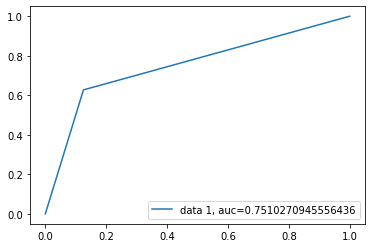

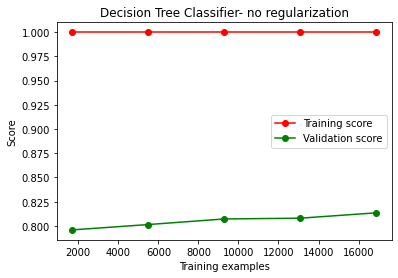

In [ ]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn import metrics
from sklearn import model_selection
######## no regularization ########
kfold = model_selection.KFold(n_splits=5)
tree_kfold =DecisionTreeClassifier()

tree_results_3=model_selection.cross_val_predict(tree_kfold, X_train, y_train, cv=kfold, method='predict')

print(classification_report(y_train,tree_results_3))

auc = metrics.roc_auc_score(y_train, tree_results_3)
fpr, tpr, _ = metrics.roc_curve(y_train,  tree_results_3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(tree_kfold, X_train, y_train, cv=kfold, return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Decision Tree Classifier- no regularization')
plt.legend(loc='best')







              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90     15887
         1.0       0.76      0.51      0.61      5226

    accuracy                           0.84     21113
   macro avg       0.81      0.73      0.76     21113
weighted avg       0.83      0.84      0.83     21113



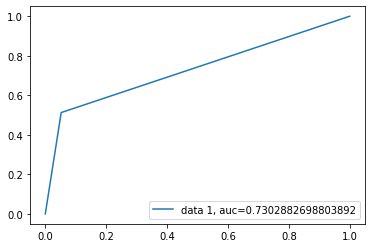

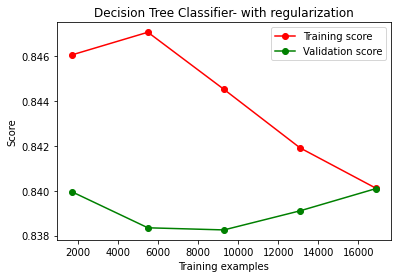

In [ ]:
######## with regularization ########

tree_kfold = DecisionTreeClassifier(criterion='entropy', max_depth = 3, ccp_alpha=0.01 )

tree_results_3=model_selection.cross_val_predict(tree_kfold, X_train, y_train, cv=kfold, method='predict')

print(classification_report(y_train,tree_results_3))

auc = metrics.roc_auc_score(y_train, tree_results_3)
fpr, tpr, _ = metrics.roc_curve(y_train,  tree_results_3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(tree_kfold, X_train, y_train, cv=kfold, return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Decision Tree Classifier- with regularization')
plt.legend(loc='best')



In [ ]:
######## Grid Search ########

from sklearn.model_selection import cross_val_score
grid_cv_scores_mean = []
grid_params=[]
grid_model=[]


criterion=['gini','entropy']
ccp_alphas2=[0.0001,0.001,0.01,0.05,1]
depth=[2,3,4,5,6,7,8,9,10]

for i in criterion:
 for c in ccp_alphas2:
  for d in depth:

    grid_params.append([i, c,  d])
    grid_tree_kfold = DecisionTreeClassifier(criterion=i, max_depth = d, ccp_alpha=c )
    grid_model.append(grid_tree_kfold)
    grid_scores = model_selection.cross_val_score(grid_tree_kfold, X_train, y_train, cv=kfold)
    grid_cv_scores_mean.append(grid_scores.mean())



#misclassification error
MSE = [1-x for x in grid_cv_scores_mean]
#optimal params
optimal_index = MSE.index(min(MSE))
tree_optimal_param= grid_params[optimal_index]
tree_optimal_model= grid_model[optimal_index]

print(tree_optimal_param)


tree_optimal_model.fit(X_train,y_train)



['gini', 0.0001, 10]


DecisionTreeClassifier(ccp_alpha=0.0001, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

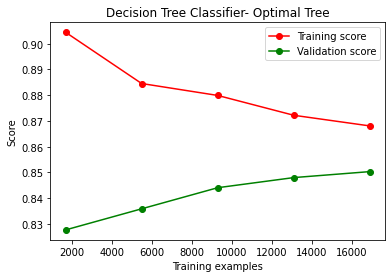

In [ ]:

(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(tree_optimal_model, X_train, y_train, cv=kfold, return_times=True)


train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Decision Tree Classifier- Optimal Tree')
plt.legend(loc='best')


#SVM

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     15887
         1.0       0.99      0.14      0.25      5226

    accuracy                           0.79     21113
   macro avg       0.89      0.57      0.56     21113
weighted avg       0.83      0.79      0.72     21113



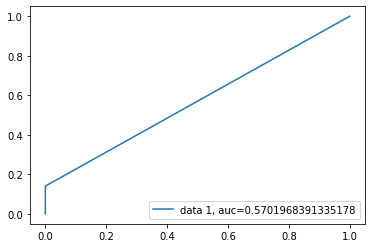

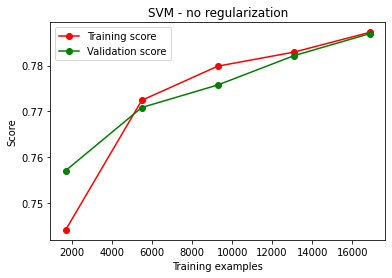

In [ ]:
######## no regularization ########
from sklearn import svm
from sklearn import model_selection

svm_kfold = svm.SVC(kernel='rbf')

svm_results_3=model_selection.cross_val_predict(svm_kfold, X_train, y_train, cv=kfold, method='predict')

print(classification_report(y_train,svm_results_3))

auc = metrics.roc_auc_score(y_train, svm_results_3)
fpr, tpr, _ = metrics.roc_curve(y_train,  svm_results_3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(svm_kfold, X_train, y_train, cv=kfold, return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('SVM - no regularization')
plt.legend(loc='best')




              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88     15887
         1.0       0.85      0.20      0.32      5226

    accuracy                           0.79     21113
   macro avg       0.82      0.59      0.60     21113
weighted avg       0.80      0.79      0.74     21113



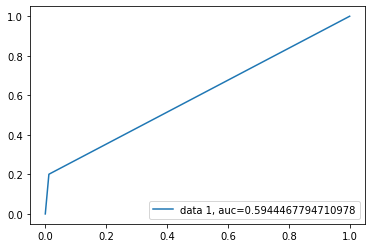

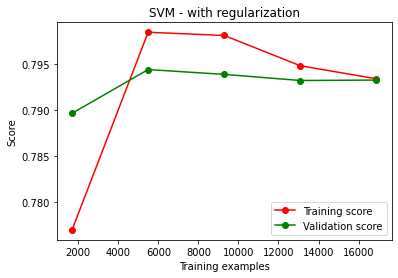

In [ ]:
######## with regularization ########
svm_kfold = svm.SVC(C=10.0, kernel='rbf')

svm_results_3=model_selection.cross_val_predict(svm_kfold, X_train, y_train, cv=kfold, method='predict')

print(classification_report(y_train,svm_results_3))

auc = metrics.roc_auc_score(y_train, svm_results_3)
fpr, tpr, _ = metrics.roc_curve(y_train,  svm_results_3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(svm_kfold, X_train, y_train, cv=kfold, return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('SVM - with regularization')
plt.legend(loc='best')





In [ ]:
######## Grid Search ########

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


tuned_parameters =  [{'kernel': ['sigmoid','rbf'], 'class_weight' :['balanced',None], 'C': [0.001, 0.10, 0.1, 1,2.5, 5, 10] }]              


svm_grid = GridSearchCV(SVC(), tuned_parameters,scoring='accuracy', cv=kfold, refit='cv_results_' )

svm_grid.fit(X_train,y_train)
best_svm=svm_grid.best_params_
print(svm_grid.best_params_)


{'C': 5, 'class_weight': None, 'kernel': 'rbf'}


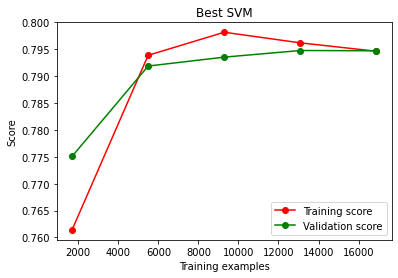

In [ ]:
svm_best = svm.SVC(C=5, class_weight=None, kernel= 'rbf')

(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(svm_best, X_train, y_train, cv=kfold, return_times=True)


train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Best SVM')
plt.legend(loc='best')


#Logistic Regression

              precision    recall  f1-score   support

         0.0       0.80      0.97      0.87     15887
         1.0       0.72      0.26      0.38      5226

    accuracy                           0.79     21113
   macro avg       0.76      0.61      0.63     21113
weighted avg       0.78      0.79      0.75     21113



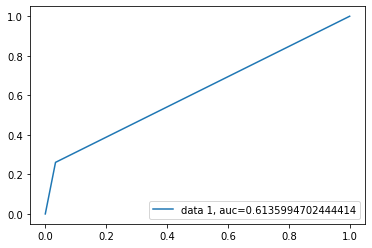

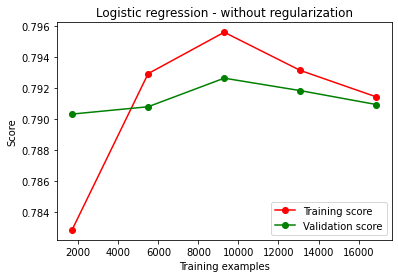

In [ ]:
######## without regularization ########

from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression( penalty='none' , solver='lbfgs',max_iter=5000)

log_reg_results=model_selection.cross_val_predict(log_reg, X_train, y_train, cv=kfold, method='predict')

print(classification_report(y_train,log_reg_results))

auc = metrics.roc_auc_score(y_train, log_reg_results)
fpr_log, tpr_log, _ = metrics.roc_curve(y_train,  log_reg_results)
plt.plot(fpr_log, tpr_log,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(log_reg, X_train, y_train, cv=kfold, return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Logistic regression - without regularization')
plt.legend(loc='best')





              precision    recall  f1-score   support

         0.0       0.80      0.97      0.87     15887
         1.0       0.72      0.26      0.38      5226

    accuracy                           0.79     21113
   macro avg       0.76      0.61      0.63     21113
weighted avg       0.78      0.79      0.75     21113



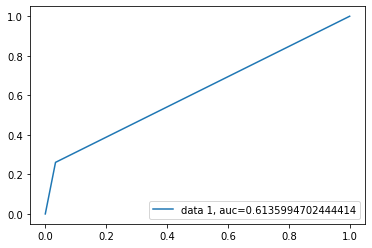

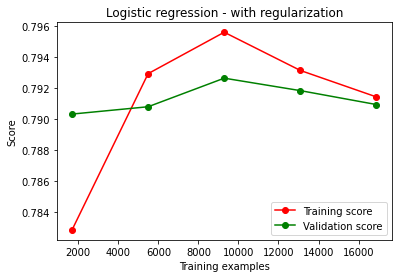

In [ ]:
######## with regularization ########

from sklearn.linear_model import LogisticRegression


log_reg2 =  LogisticRegression(C=5, solver='lbfgs', penalty='l2',max_iter=5000)

log_reg_results2=model_selection.cross_val_predict(log_reg2, X_train, y_train, cv=kfold, method='predict')

print(classification_report(y_train,log_reg_results2))
auc = metrics.roc_auc_score(y_train, log_reg_results2)
fpr_log, tpr_log, _ = metrics.roc_curve(y_train,  log_reg_results2)
plt.plot(fpr_log, tpr_log,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(log_reg, X_train, y_train, cv=kfold, return_times=True)

train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Logistic regression - with regularization')
plt.legend(loc='best')





In [ ]:
from sklearn.model_selection import GridSearchCV

logic_params =  [{'penalty': ['l1'], 'C':[0.001, 0.01, 0.1, 1,5, 10],
                     'solver':['liblinear'],'max_iter':[100,1000,5000]},
                 {'penalty': ['l2'], 'C':[0.001, 0.01, 0.1, 1,5, 10],
                     'solver':['lbfgs', 'liblinear'],'max_iter':[100,1000,5000]}]              


logic_grid = GridSearchCV(LogisticRegression(), param_grid=logic_params,scoring='accuracy', cv=kfold, refit='cv_results_')
logic_grid.fit(X_train, y_train)


best_logic_reg=logic_grid.best_params_
print(logic_grid.best_params_)





{'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


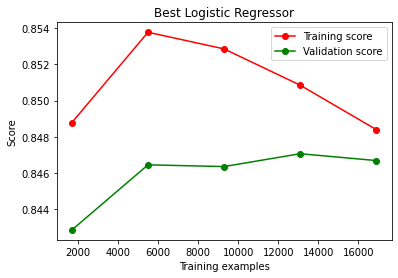

In [ ]:
log_reg3 =  LogisticRegression(C=1, solver='liblinear', penalty='l1',max_iter=100)

(train_sizes, train_scores, test_scores, _, _) = model_selection.learning_curve(log_reg3, X_train, y_train, cv=kfold, return_times=True)


train_scores_mean = np.mean(train_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title('Best Logistic Regressor')
plt.legend(loc='best')


#Evaluation

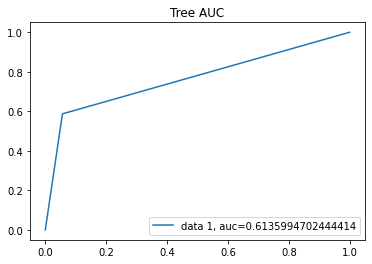

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91      6767
         1.0       0.78      0.59      0.67      2282

    accuracy                           0.85      9049
   macro avg       0.83      0.77      0.79      9049
weighted avg       0.85      0.85      0.85      9049



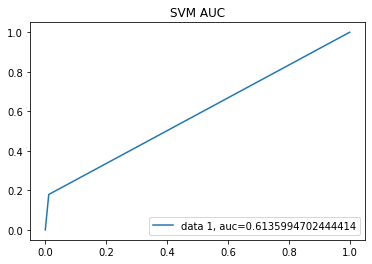

              precision    recall  f1-score   support

         0.0       0.78      0.99      0.87      6767
         1.0       0.84      0.18      0.30      2282

    accuracy                           0.78      9049
   macro avg       0.81      0.58      0.58      9049
weighted avg       0.80      0.78      0.73      9049



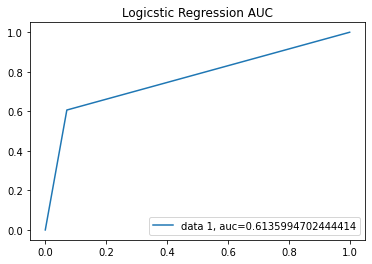

              precision    recall  f1-score   support

         0.0       0.88      0.93      0.90      6767
         1.0       0.74      0.61      0.67      2282

    accuracy                           0.85      9049
   macro avg       0.81      0.77      0.78      9049
weighted avg       0.84      0.85      0.84      9049



In [ ]:
from sklearn.metrics import plot_confusion_matrix

tree_pred=tree_optimal_model.predict(X_test)
svm_pred=svm_grid.predict(X_test)
logic_pred=logic_grid.predict(X_test)

tree_pred=tree_pred.tolist()
svm_pred=svm_pred.tolist()
logic_pred=logic_pred.tolist()

##Decision trees test evaluation
tree_eval=classification_report( y_test, tree_pred)
auc_tree = metrics.roc_auc_score(y_test, tree_pred)
tree_conf=confusion_matrix( y_test, tree_pred)
fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test, tree_pred)
plt.plot(fpr_tree, tpr_tree,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Tree AUC')
plt.show()
print(tree_eval)


##SVM test evaluation
svm_eval=classification_report( y_test, svm_pred)
auc_svm = metrics.roc_auc_score(y_test, svm_pred)
svm_conf=confusion_matrix( y_test, svm_pred)
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test, svm_pred)
plt.plot(fpr_svm, tpr_svm,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('SVM AUC')
plt.show()
print(svm_eval)

##Logicstic Regression test evaluation
logic_eval=classification_report( y_test, logic_pred)
logic_conf=confusion_matrix( y_test, logic_pred)
auc_logic = metrics.roc_auc_score(y_test, logic_pred)
fpr_logic, tpr_logic, _ = metrics.roc_curve(y_test, logic_pred)
plt.plot(fpr_logic, tpr_logic,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Logicstic Regression AUC')
plt.show()
print(logic_eval)


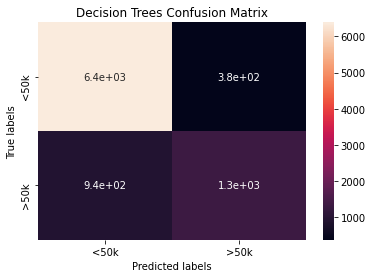

In [ ]:
import seaborn as sns
tree_ax= plt.subplot()
sns.heatmap(tree_conf, annot=True, ax = tree_ax); 

# labels, title and ticks
tree_ax.set_xlabel('Predicted labels');tree_ax.set_ylabel('True labels'); 
tree_ax.set_title('Decision Trees Confusion Matrix'); 
tree_ax.xaxis.set_ticklabels(['<50k', '>50k']); tree_ax.yaxis.set_ticklabels(['<50k', '>50k']);
#DANIEL TACHNIS labels = ['TN','FP','FN','TP']



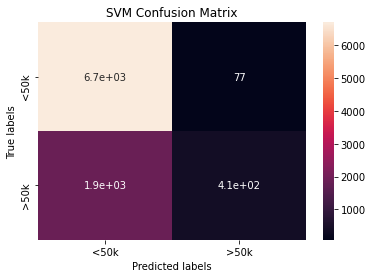

In [ ]:
svm_ax= plt.subplot()
sns.heatmap(svm_conf, annot=True, ax = svm_ax); 

# labels, title and ticks
svm_ax.set_xlabel('Predicted labels');svm_ax.set_ylabel('True labels'); 
svm_ax.set_title('SVM Confusion Matrix'); 
svm_ax.xaxis.set_ticklabels(['<50k', '>50k']); svm_ax.yaxis.set_ticklabels(['<50k', '>50k']);


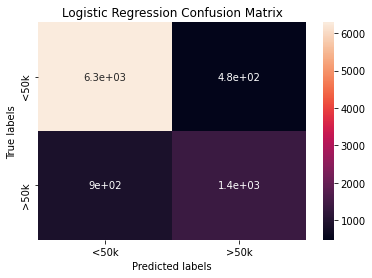

In [ ]:
log_ax= plt.subplot()
sns.heatmap(logic_conf, annot=True, ax = log_ax); 

# labels, title and ticks
log_ax.set_xlabel('Predicted labels');log_ax.set_ylabel('True labels'); 
log_ax.set_title('Logistic Regression Confusion Matrix'); 
log_ax.xaxis.set_ticklabels(['<50k', '>50k']); log_ax.yaxis.set_ticklabels(['<50k', '>50k']);

#Ensemble

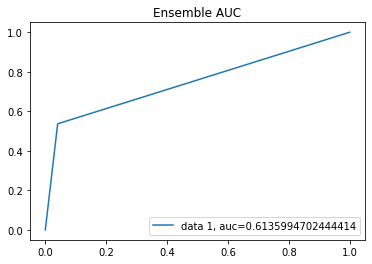

              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91      6767
         1.0       0.82      0.54      0.65      2282

    accuracy                           0.85      9049
   macro avg       0.84      0.75      0.78      9049
weighted avg       0.85      0.85      0.84      9049



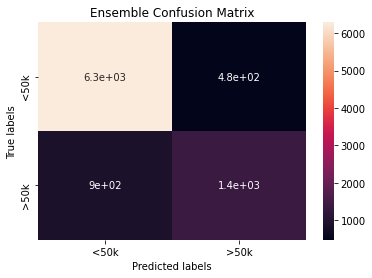

In [ ]:

ensemble=[]

sum_pred=[x + y+ z for x, y,z in zip(tree_pred, svm_pred,logic_pred)]

for i in sum_pred:
  if i>1.0:
   ensemble.append(1.0)
  else:
   ensemble.append(0.0)

ensemble_eval=classification_report( y_test, ensemble)
auc_ensemble = metrics.roc_auc_score(y_test, ensemble)
fpr_ensemble, tpr_ensemble, _ = metrics.roc_curve(y_test, ensemble)
plt.plot(fpr_ensemble, tpr_ensemble,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.title('Ensemble AUC')
plt.show()
print(ensemble_eval)

ens_conf=confusion_matrix( y_test, ensemble)


ens_ax= plt.subplot()
sns.heatmap(logic_conf, annot=True, ax = ens_ax); 

# labels, title and ticks
ens_ax.set_xlabel('Predicted labels');ens_ax.set_ylabel('True labels'); 
ens_ax.set_title('Ensemble Confusion Matrix'); 
ens_ax.xaxis.set_ticklabels(['<50k', '>50k']); ens_ax.yaxis.set_ticklabels(['<50k', '>50k']);